## Course: DSC530
## Assignment: 8.2, Hypothesis Testing and Linear Least Squares
## Name: Laura Hoffmann
## Date: 10/22/2020

### Setup

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import random
import thinkstats2
import hypothesis
import thinkplot

In [2]:
import first
live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

# 9-1

In [3]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
class CorrelationPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
class PregLengthTest(thinkstats2.HypothesisTest):
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))
        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat
    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [4]:
def RunTests(live, iters=1000):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)
    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [5]:
print("n", "     test 1", " test 2", " test 3", " test 4")
n = len(live)
for _ in range(8):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

n      test 1  test 2  test 3  test 4
9148	0.16	0.00	0.00	0.00
4574	0.32	0.01	0.00	0.00
2287	0.21	0.00	0.00	0.00
1143	0.07	0.38	0.01	0.00
571	0.14	0.76	0.05	0.02
285	0.04	0.07	0.83	0.10
142	0.55	0.20	0.27	0.83
71	0.86	0.93	0.70	0.00


#### While n represents the sample size, 
test 1 is the test on difference in mean pregnancy length

test 2 is the test on difference in mean birth weight

test 3 is the test on correlation of mother's age and birth weight of the baby

test 4 is the chi-square test of pregnancy length

#### Using this data set the results are kind of inconsistent. We expect the positive test results with large sample sizes to become increasingly negative as the sample size decreases. Most of the results are positive even with small sample sizes. The results are really all over the board and don't tend to line up.

# 10-1

In [6]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

# Linear Least Squares Fit (Estimate intercept and slope)
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.993080416391812, 0.005281454169417809)

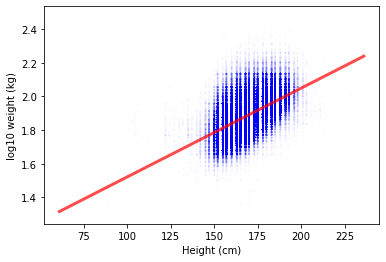

In [7]:
# Make a scatter plot of the data and show the fitted line.
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

In [8]:
# Calculate correlation
rho=(thinkstats2.Corr(heights, log_weights))
print("Rho:", rho)
# Calculate coefficient of determination
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
r2 = thinkstats2.CoefDetermination(log_weights, res)
print("R2 log weighted:", r2)

Rho: 0.5317282605983434
R2 log weighted: 0.28273494311894065


#### It looks like height can predict about 28% of variance in weight.

In [9]:
# Calculating coefficient of determination without log
    # This I just did because I was curious about how the log weight affected results
res2 = thinkstats2.Residuals(heights, weights, inter, slope)
r2no_log = thinkstats2.CoefDetermination(weights, res)
print("R2 no log:", r2no_log)

R2 no log: 0.9999800059206752


In [10]:
# Confirming R2 = p2
print(round(rho**2 - r2, 4))

-0.0


#### Since the results are 0 we can see that R2 and p2 are equal to one another.

P-Value: 0
Confidence Interval: (0.0052527490220660505, 0.005302261221807376)
Mean: 0.005279890248571405
Standard Error of the Mean: 1.452021176796807e-05


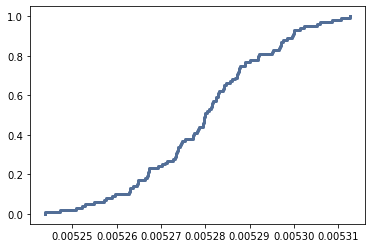

In [11]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)
pvalue = cdf[0]
print("P-Value:", pvalue)
ci = cdf.Percentile(5), cdf.Percentile(95)
print("Confidence Interval:", ci)
mean = thinkstats2.Mean(slopes)
print("Mean:", mean)
stderr = thinkstats2.Std(slopes)
print("Standard Error of the Mean:", stderr)


In [12]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print("Mean:", mean)
    print("Standard Error:", stderr)
    print("Confidence Interval:", ci)

In [13]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
print(Summarize(estimates_unweighted))

Mean: 168.95704293740778
Standard Error: 0.015225872925355965
Confidence Interval: (168.930483134259, 168.98327573313932)
None


In [14]:
estimates_weighted = [thinkstats2.ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
print(Summarize(estimates_weighted))

Mean: 170.49856224357808
Standard Error: 0.01606534973446429
Confidence Interval: (170.46597293801412, 170.52248428626285)
None


#### When weighted, the estimated mean height is about 1.5 cm more than unweighted. The sampling error is a mere .01 which is a lot smaller than the 1.5 difference.